In [ ]:
!unzip /content/good.zip -d /content/dataset/


Archive:  /content/good.zip
replace /content/dataset/good/000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace /content/dataset/good/001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace /content/dataset/good/002.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip /content/test.zip -d /content/dataset/

Archive:  /content/test.zip
replace /content/dataset/test/broken_large/000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [ ]:
class MVNetTrainDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = 0  # Training only on normal images
        return image, label


In [ ]:
class MVNetTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []


        for category in ["good", "contamination", "broken_small", "broken_large"]:
            folder_path = os.path.join(root_dir, category)
            label = 0 if category == "good" else 1  # 0 for normal, 1 for anomalies


            for file in os.listdir(folder_path):
                if file.endswith(('.png', '.jpg', '.jpeg')):
                    self.image_files.append(os.path.join(folder_path, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# Define dataset paths
train_path = "/content/dataset/good"  # Contains only normal images
test_path = "/content/dataset/test"    # Contains normal & anomalous images

# Load datasets
train_dataset = MVNetTrainDataset(root_dir=train_path, transform=transform)
test_dataset = MVNetTestDataset(root_dir=test_path, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"✅ Training images: {len(train_dataset)}")
print(f"✅ Testing images: {len(test_dataset)}")


✅ Training images: 209
✅ Testing images: 83


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [ ]:

import torch
import torch.nn as nn
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.preprocessing import StandardScaler


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = SimpleCNN().to(device)
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
)

In [ ]:

def extract_features(loader):
    features = []
    labels = []

    with torch.no_grad():
        for images, label in loader:
            images = images.to(device)
            feature = model(images)  # Extract features
            features.append(feature.cpu().numpy())
            labels.append(label.cpu().numpy())

    return np.concatenate(features, axis=0), np.concatenate(labels, axis=0)


In [ ]:

train_features, train_labels = extract_features(train_loader)

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
X_train_normal = train_features[train_labels == 0]

svm = OneClassSVM(nu=0.1, kernel="rbf", gamma='scale')
svm.fit(X_train_normal)

print("✅ One-Class SVM Model Trained!")


✅ One-Class SVM Model Trained!


In [ ]:
test_features, test_labels = extract_features(test_loader)

test_features = scaler.transform(test_features)

# Predict using One-Class SVM
y_pred_svm = svm.predict(test_features)
y_pred_svm = np.where(y_pred_svm == 1, 0, 1)


accuracy = accuracy_score(test_labels, y_pred_svm)
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Classification Report:\n{classification_report(test_labels, y_pred_svm)}")


✅ Accuracy: 0.8193
✅ Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.55      0.59        20
           1       0.86      0.90      0.88        63

    accuracy                           0.82        83
   macro avg       0.76      0.73      0.74        83
weighted avg       0.81      0.82      0.81        83



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


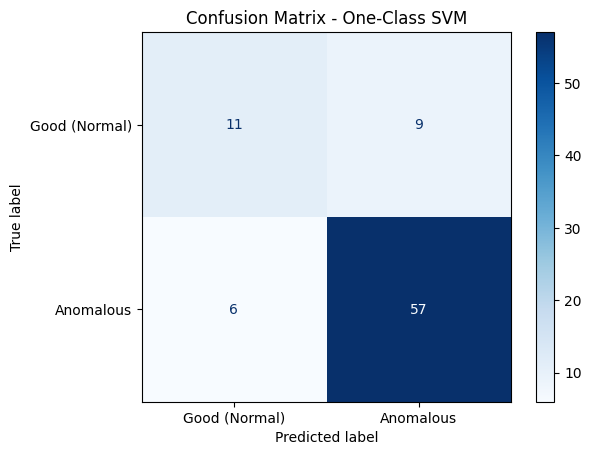

In [ ]:
cm = confusion_matrix(test_labels, y_pred_svm)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good (Normal)", "Anomalous"])
cm_display.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix - One-Class SVM")
plt.show()
